In [1]:
import tomllib

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

import AEIC.trajectories.builders as tb
from AEIC.config import Config, config
from AEIC.missions import Mission
from AEIC.performance.models import PerformanceModel
from AEIC.performance.models.legacy import ROCDFilter
from AEIC.trajectories import TrajectoryStore, GroundTrack

Default configuration.

In [2]:
Config.load();

Sample performance model (updated: single mass for descent) and a performance model built from a randomly selected PTF file.

In [3]:
pm1 = PerformanceModel.load(config.file_location('performance/sample_performance_model.toml'))

In [4]:
pm2 = PerformanceModel.load(config.file_location('performance/random_test_ptf.toml'))

Built-in sample missions.

In [5]:
missions_file = config.file_location('missions/sample_missions_10.toml')
with open(missions_file, 'rb') as f:
    mission_dict = tomllib.load(f)
sample_missions = Mission.from_toml(mission_dict)

Fly mission with legacy trajectory builder.

In [6]:
builder = tb.LegacyBuilder(options=tb.Options(iterate_mass=False))
mis = sample_missions[0]
traj1 = builder.fly(pm1, mis)
traj2 = builder.fly(pm2, mis)

Load golden test comparison trajectory: this was simulated using the sample performance model, but with three mass values for descent, i.e., not matching up to what would be in a PTF file.

In [7]:
with TrajectoryStore.open(base_file='../tests/data/golden/test_trajectories_golden.nc') as ts:
    comparison_traj = ts[0]

Comparison plots: see comments below.

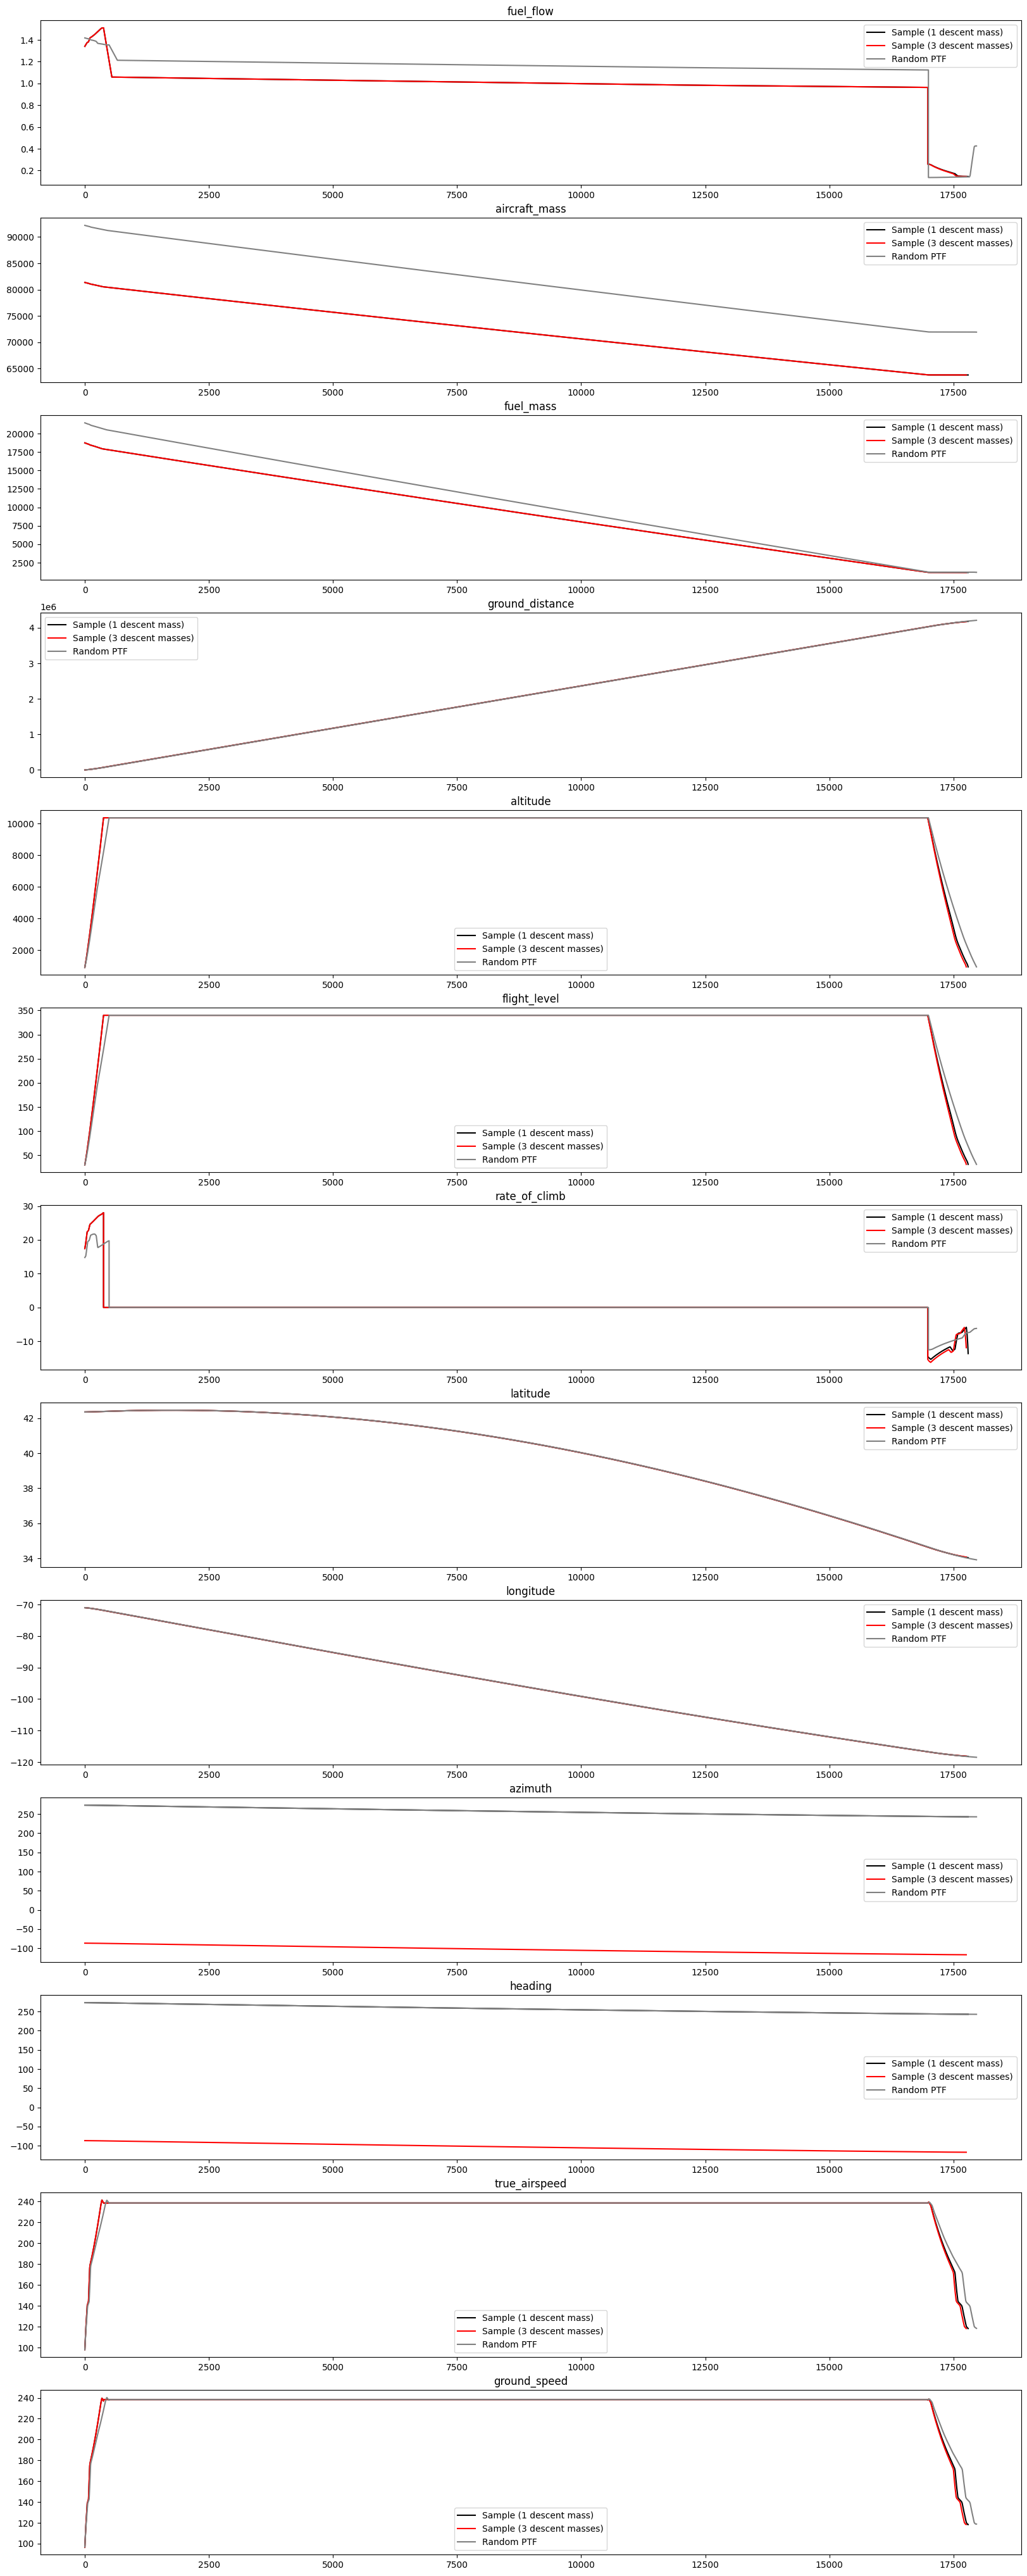

In [10]:
attrs = [
    'fuel_flow',
    'aircraft_mass',
    'fuel_mass',
    'ground_distance',
    'altitude',
    'flight_level',
    'rate_of_climb',
    'latitude',
    'longitude',
    'azimuth',
    'heading',
    'true_airspeed',
    'ground_speed',
]
fig, axs = plt.subplots(len(attrs), 1, figsize=(20, 4 * len(attrs)))
for i, a in enumerate(attrs):
    axs[i].plot(traj1.flight_time, getattr(traj1, a), color='black', label='Sample (1 descent mass)')
    axs[i].plot(comparison_traj.flight_time, getattr(comparison_traj, a), color='red', label='Sample (3 descent masses)')
    axs[i].plot(traj2.flight_time, getattr(traj2, a), color='grey', label='Random PTF')
    axs[i].set_title(a)
    axs[i].legend()

The simulations flown using a performance model built from a randomly selected PTF file are different from those using the sample performance model, as you'd expect.

For the two "sample" performance models, the only differences in the simulations arise during descent, because one performance model (grey lines: the original `sample_performance_model.toml` that Adi made) has descent fuel flow and ROCD data for all three mass values (which is not what you would find in a PTF file) and the other (red lines: `sample_performance_model.toml` hand-edited to remove the low and high mass values for descent) has descent fuel flow and ROCD data only for the nominal mass value (which is what you get in PTF files).